In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import json

from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import stats
from scipy.stats import gaussian_kde

In [2]:
from scipy.spatial import Delaunay
import numpy as np

# https://stackoverflow.com/questions/50549128/boundary-enclosing-a-given-set-of-points

#  matlab boundary - https://stackoverflow.com/questions/31836709/what-algorithm-does-matlabs-boundary-function-use

# https://www.mathworks.com/help/matlab/ref/boundary.html

#  javascript implementation of hull - https://github.com/AndriiHeonia/hull

# alpha shape https://en.wikipedia.org/wiki/Alpha_shape
# https://doc.cgal.org/latest/Alpha_shapes_2/index.html

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [3]:
def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst

In [85]:
"""main function"""
folders = [f for f in listdir("data/input/")]
# print(folders)
for folder in folders:
    onlyfiles = [f for f in listdir("data/input/{}".format(folder)) ]
    for file in onlyfiles:
        df = pd.read_csv('data/input/{}/{}'.format(folder,file))
        
        name = file.replace(".csv","")
        
        # # Constructing the input point data
        x = df['Points:0'].to_numpy()
        y = df['Points:1'].to_numpy()

        inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
        # print(inside)
        points = np.vstack([x[inside], y[inside]]).T
        # print(points)

        # Computing the alpha shape
        edges = alpha_shape(points, alpha=0.25, only_outer=True)
        
#         getting ordered boundaries
        orderedBoundaries = stitch_boundaries(edges)
    
        maxL = []
        index = []
        for i in range(len(orderedBoundaries)):
        #     print(len(orderedBoundaries[i]))
            if len(orderedBoundaries[i]) > 6:
                maxL.append(len(orderedBoundaries[i]))
                index.append(i)
    
        count = 0
        shapeData = []

        for i in index:
            bound = []
            count = 0
            for j in orderedBoundaries[i]:    
                if count == 0:
                    bound.append({'X': points[j[0]][0], 'Y': points[j[0]][1]})
                    bound.append({'X': points[j[1]][0], 'Y': points[j[1]][1]})
                    count = count + 1
                else:
                    bound.append({'X': points[j[1]][0], 'Y': points[j[1]][1]})

            shapeData.append(bound)
                

        with open('data/output/{}/{}.json'.format(folder, name), 'w') as outfile:
            json.dump(shapeData, outfile)
        print("extracted {}".format(file))



C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


extracted 0.1.csv


C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


extracted 0.11.csv
extracted 0.12.csv
extracted 0.13.csv
extracted 0.14.csv
extracted 0.15.csv
extracted 0.16.csv
extracted 0.17.csv
extracted 0.18.csv
extracted 0.19.csv
extracted 0.2.csv
extracted 0.1.csv
extracted 0.11.csv
extracted 0.12.csv
extracted 0.13.csv
extracted 0.14.csv
extracted 0.15.csv
extracted 0.16.csv
extracted 0.17.csv
extracted 0.18.csv
extracted 0.19.csv
extracted 0.2.csv
extracted 0.1.csv
extracted 0.11.csv
extracted 0.12.csv
extracted 0.13.csv
extracted 0.14.csv
extracted 0.15.csv
extracted 0.16.csv
extracted 0.17.csv
extracted 0.18.csv
extracted 0.19.csv
extracted 0.2.csv
extracted 210.csv
extracted 211.csv
extracted 212.csv
extracted 213.csv
extracted 214.csv
extracted 215.csv
extracted 216.csv
extracted 217.csv
extracted 218.csv
extracted 219.csv


C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


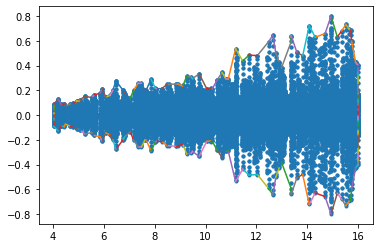

In [88]:
df = pd.read_csv('data/input/contrails1/0.2.csv')
# # Constructing the input point data
x = df['Points:0'].to_numpy()
y = df['Points:1'].to_numpy()

inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
# print(inside)
points = np.vstack([x[inside], y[inside]]).T
# print(points)

# Computing the alpha shape
edges = alpha_shape(points, alpha=0.25, only_outer=True)

# Plotting the output
plt.figure()
plt.plot(points[:, 0], points[:, 1], '.')
# plt.ylim([-1, 1])
for i, j in edges:
#     print(i, j, points[[i, j], 0], points[[i, j], 1])
    
    plt.plot(points[[i, j], 0], points[[i, j], 1])


plt.show()

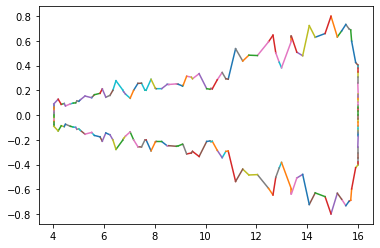

In [89]:
plt.figure()

for i, j in edges:
#     print(i, j, points[[i, j], 0], points[[i, j], 1])
    
    plt.plot(points[[i, j], 0], points[[i, j], 1])


plt.show()

In [90]:
orderedBoundaries = stitch_boundaries(edges)

In [91]:
maxL = []
index = []
for i in range(len(orderedBoundaries)):
#     print(len(orderedBoundaries[i]))
    if len(orderedBoundaries[i]) > 6:
        maxL.append(len(orderedBoundaries[i]))
        index.append(i)
        
print(index, maxL)

[0] [250]


In [92]:
X = []
Y = []
count = 0


for i in index:
    bound = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            X.append(points[j[0]][0])
            X.append(points[j[1]][0])
            Y.append(points[j[0]][1])
            Y.append(points[j[1]][1])
            count = count + 1
        else:
            X.append(points[j[1]][0])
            Y.append(points[j[1]][1])
    shapeData.append(bound)


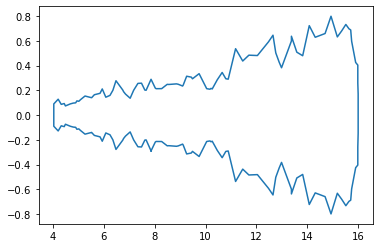

In [93]:
plt.figure()
plt.plot(X,Y)
plt.show()

C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


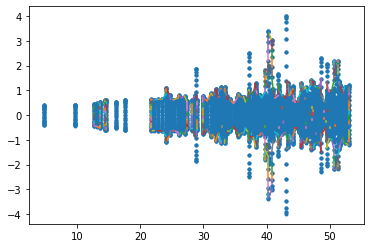

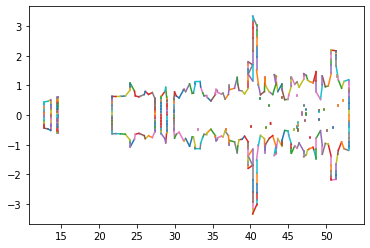

C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


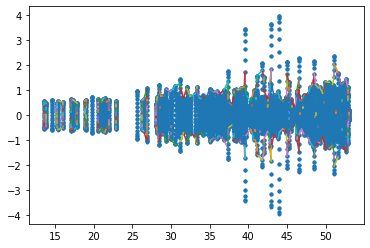

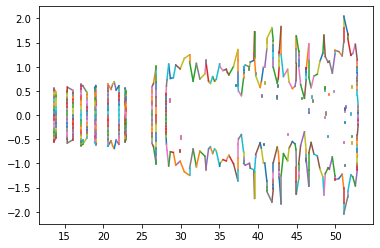

C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


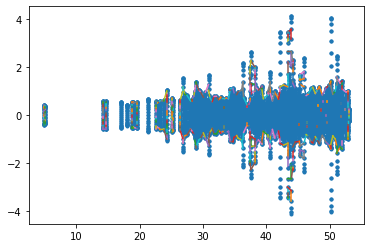

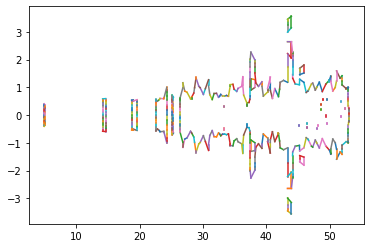

C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


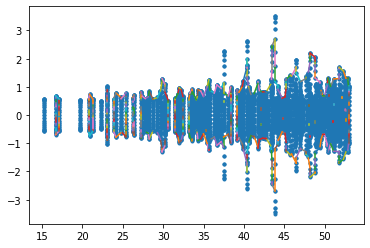

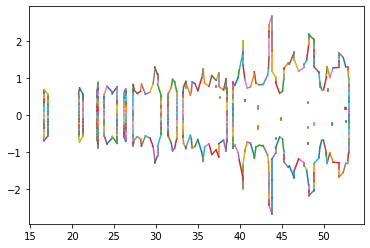

C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


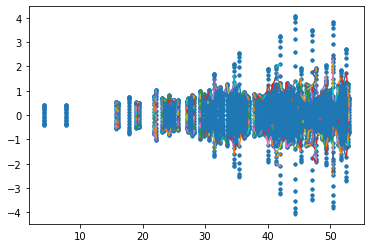

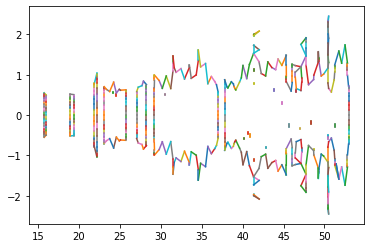

C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


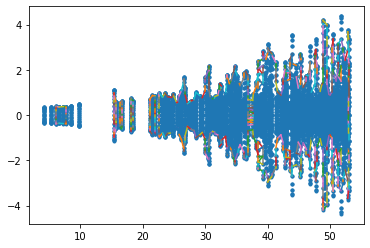

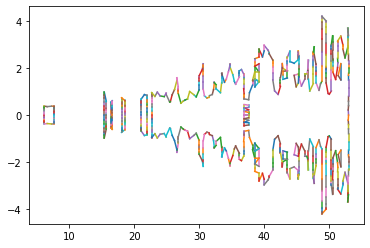

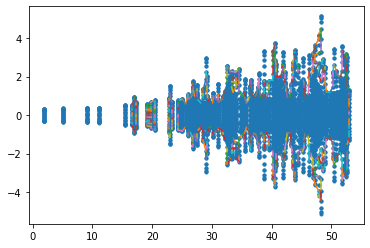

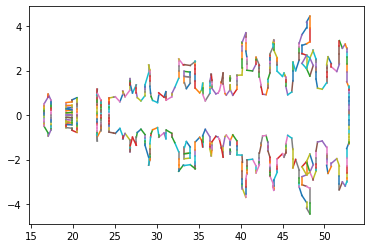

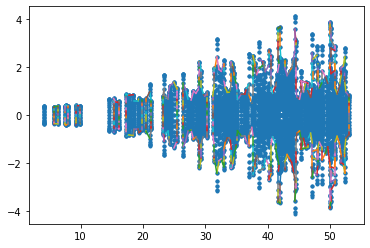

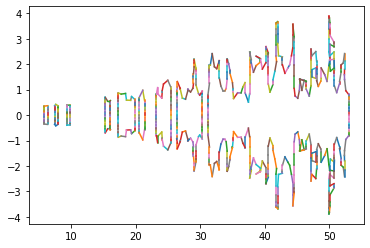

C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


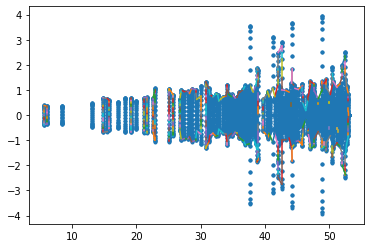

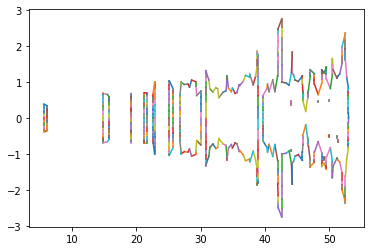

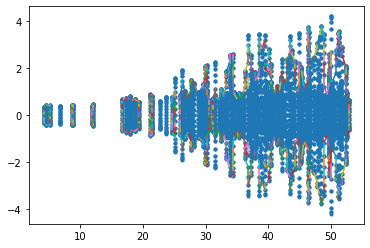

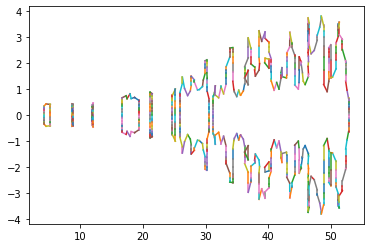

In [5]:
# folders = [f for f in listdir("data/input/")]
folders = ['newData']
# print(folders)
for folder in folders:
    onlyfiles = [f for f in listdir("data/input/{}".format(folder)) ]
    for file in onlyfiles:
        df = pd.read_csv('data/input/{}/{}'.format(folder,file))
        
        x = df['Points:0'].to_numpy()
        y = df['Points:1'].to_numpy()

        inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
        # print(inside)
        points = np.vstack([x[inside], y[inside]]).T
        # print(points)

        # Computing the alpha shape
        edges = alpha_shape(points, alpha=0.35, only_outer=True)

        # Plotting the output
        plt.figure()
        plt.plot(points[:, 0], points[:, 1], '.')
        # plt.ylim([-1, 1])
        for i, j in edges:
        #     print(i, j, points[[i, j], 0], points[[i, j], 1])

            plt.plot(points[[i, j], 0], points[[i, j], 1])


        plt.show()

        plt.figure()

        for i, j in edges:
        #     print(i, j, points[[i, j], 0], points[[i, j], 1])

            plt.plot(points[[i, j], 0], points[[i, j], 1])


        plt.show()

In [7]:
folders = [f for f in listdir("data/input/")]
folders

['contrails1', 'contrails2', 'contrails3', 'newData']

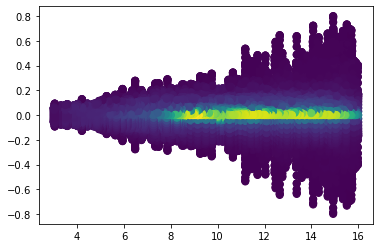

In [181]:
# Generate fake data
x = df['Points:0'].to_numpy()
y = df['Points:1'].to_numpy()

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.show()

C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\evladmin\Anaconda3\envs\server-png\lib\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


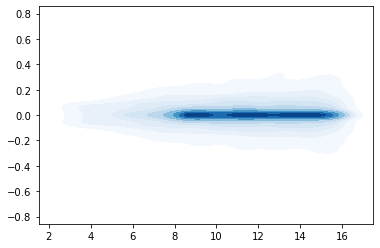

In [182]:
ax = sns.kdeplot(x, y, cmap="Blues", shade=True, shade_lowest=False)

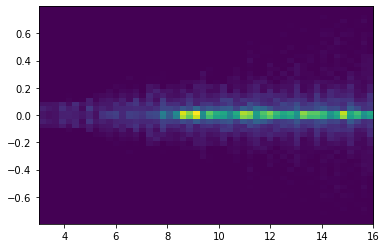

In [183]:
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(50))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.show()

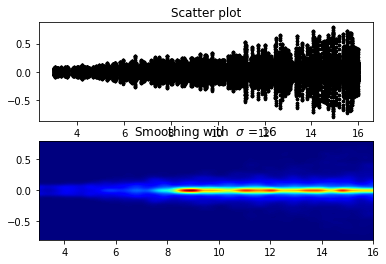

In [184]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


fig, axs = plt.subplots(2, 1)

# # Generate some test data
# x = np.random.randn(1000)
# y = np.random.randn(1000)

sigmas = [0, 16]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(x, y, 'k.', markersize=5)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(x, y, s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet, aspect='auto')
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

[[ 3.0403   -0.092567]
 [14.932    -0.79825 ]
 [15.516    -0.7319  ]
 [15.707    -0.68734 ]
 [15.986    -0.40375 ]
 [16.       -0.17058 ]
 [16.        0.17058 ]
 [15.986     0.40375 ]
 [15.707     0.68734 ]
 [15.516     0.7319  ]
 [14.932     0.79825 ]
 [ 3.0403    0.092567]
 [ 2.9994    0.058095]
 [ 2.9994   -0.058095]]


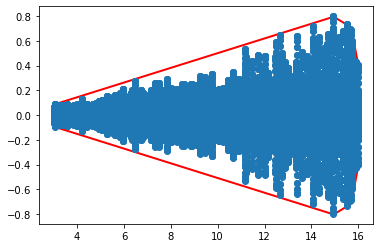

In [185]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from matplotlib.collections import PolyCollection


fig, ax = plt.subplots()

# length = 1000

#using some normally distributed data as example:
x = df['Points:0'].to_numpy()
y = df['Points:1'].to_numpy()

length = len(x)

points = np.concatenate([x,y]).reshape((2,length)).T
hull = ConvexHull(points)



ax.scatter(x,y)

print(points[hull.vertices,:])

ax.add_collection(PolyCollection(
    [points[hull.vertices,:]],
    edgecolors='r',
    facecolors='w',
    linewidths=2,
    zorder=-1,
    ))



plt.show()

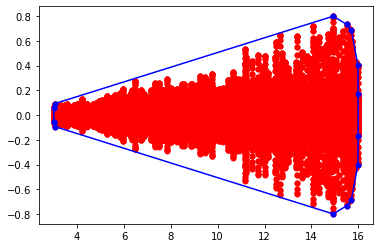

In [186]:
import random
import sys
import matplotlib.pyplot as plt

CLOCKWISE = -1
COLLINEAR = 0
COUNTERCLOCKWISE = +1
eps = sys.float_info.epsilon


def orientation(a, b):
    x0, y0 = a
    x1, y1 = b
    cross = x0 * y1 - x1 * y0
    if cross > eps:
        return COUNTERCLOCKWISE
    elif cross < -eps:
        return CLOCKWISE
    else:
        return COLLINEAR


def same_halfplane(a, b):
    x0, y0 = a
    x1, y1 = b
    dot = x0 * x1 + y0 * y1
    if dot >= eps:
        return True
    elif dot < eps:
        return False


def jarvis(points):
    """
    http://cgi.di.uoa.gr/~compgeom/pycgalvisual/whypython.shtml
    Jarvis Convex Hull algorithm.
    """
    points = points[:]
    r0 = min(points)
    hull = [r0]
    r, u = r0, None
    remainingPoints = [x for x in points if x not in hull]
    while u != r0 and remainingPoints:
        u = random.choice(remainingPoints)
        for t in points:
            a = (u[0] - r[0], u[1] - r[1])
            b = (t[0] - u[0], t[1] - u[1])
            if (t != u and
                (orientation(a, b) == CLOCKWISE or
                 (orientation(a, b) == COLLINEAR and
                  same_halfplane(a, b)))):
                u = t
        r = u
        points.remove(r)
        hull.append(r)
        try:
            remainingPoints.remove(r)
        except ValueError:
            # ValueError: list.remove(x): x not in list
            pass
    return hull

if __name__ == '__main__':
    x = df['Points:0'].to_numpy()
    y = df['Points:1'].to_numpy()
    points = list(zip(x, y))
    hull = jarvis(points)
    px, py = zip(*points)
    hx, hy = zip(*hull)
    plt.plot(px, py, 'r.', markersize=10)
    plt.plot(hx, hy, 'b.-', markersize=10)
    plt.show()